# Introduction

Another approach to defining CP(N-1) flows is to work in the Stochastic Interpolants framework. This has a much nicer training formulation than the usual forward KL, though it requires having some existing data on hand. We can use this to probe or pre-train useful ODE flows. Learned flows can be plugged into an equivalent SDE framework as well to benefit from the addition of noise. 

### Interpolant
We work in polar coordinates,
$$
z_i = \sqrt{y_i} e^{i\theta_i}
$$
The normalization constraint, $\sum_i y_i = 1$, is a linear condition in this formulation. This makes writing an interpolant very easy
$$
I(y_0, y_1, t) = (1-t) y_0 + t y_1
$$
$$
I(\theta_0, \theta_1, t) = \theta_0 + t \cdot \mathrm{wrap}(\theta_1 - \theta_0),
$$
where $\mathrm{wrap}(\theta) \in [-\pi, \pi]$ defines the branch cut of the logarithm giving the angular representation of the $U(1)$ variable interpolant.
The time derivatives are simply given by
$$
\partial_t I(y_0, y_1, t) = y_1 - y_0
$$
$$
\partial_t I(\theta_0, \theta_1, t) = \mathrm{wrap}(\theta_1 - \theta_0).
$$

### SDE formulation
To arrive at the SDE formulation, we need to be able to compute the score
\begin{equation}
\begin{aligned}
\nabla \log p_t(y,\theta) &= \frac
{\int dy_0 dy_1 d\theta_0 d\theta_1 \nabla \delta(y - I(y_0, y_1, t)) \delta(\theta - I(\theta_0, \theta_1, t)) \rho_0(y_0, \theta_0) \rho_1(y_1, \theta_1)}
{\int dy_0 dy_1 d\theta_0 d\theta_1 \delta(y - I(y_0, y_1, t)) \delta(\theta - I(\theta_0, \theta_1, t)) \rho_0(y_0, \theta_0) \rho_1(y_1, \theta_1)} \\
&= \text{boundary terms} - \frac{1}{p_t(y,\theta)} \int dy_0 dy_1 d\theta_0 d\theta_1 (1-t)^{-1} \delta(\cdot) (\nabla_0 \rho_0(y_0, \theta_0)) \rho_1(y_1, \theta_1) \\
&= \text{boundary terms} - \mathbb E \left[ (1-t)^{-1} \nabla_0 \ln \rho_0 | (y_t, \theta_t) \right]
\end{aligned}
\end{equation}
Unfortunately, the complexity seems to lie in the boundary terms. For example, we might sensibly choose a uniform prior distribution $\rho_0 = 0$, in which case the entirety of the score lives in the boundary terms.

It may be more expedient to learn a score function to initially explore the SDE possibility for CP(N-1).

# Setup

In [1]:
import analysis as al
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import tqdm.auto as tqdm

In [2]:
%matplotlib widget

In [3]:
device = 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)

In [4]:
def grab(x):
    return x.detach().cpu().numpy()
def wrap(x):
    return (x + np.pi) % (2*np.pi) - np.pi

In [5]:
Nd = 2

In [6]:
def np_to_polar(z):
    y = np.abs(z)**2
    th = np.angle(z)
    return y,th
def np_to_cartesian(y, th):
    z = np.sqrt(y) * np.exp(1j*th)
    return z
def to_polar(z):
    y = z.abs()**2
    th = torch.angle(z)
    return y,th
def to_cartesian(y, th):
    # norm = torch.sqrt(y.sum(dim=-1, keepdim=True))
    z = torch.sqrt(y) * np.exp(1j*th)
    return z

In [7]:
def generate_unif(Nc, *, size):
    # y = torch.rand(size=(size,Nc))
    # y = y / torch.sum(y, dim=1, keepdim=True)
    y = torch.distributions.exponential.Exponential(1.0).sample((size,Nc))
    y = y / torch.sum(y, dim=-1, keepdim=True)
    assert torch.all(y >= 0)
    assert torch.allclose(y.sum(-1), torch.tensor(1.0))
    th = 2*np.pi*torch.rand(size=(size,Nc)) - np.pi
    return torch.stack([y, th], dim=0)

In [8]:
def action_y_th(y: torch.Tensor, th: torch.Tensor, *, beta):
    """CP(N-1) action given unnoramlized y and th"""
    S = 0
    inds = tuple(range(len(y.shape)-Nd-1, len(y.shape)-1))
    assert len(inds) == Nd
    assert torch.all(y >= 0)
    m = (y / y.sum(dim=-1, keepdim=True)).sqrt()
    ph = torch.exp(1j*th)
    for mu,ind in zip(range(Nd), inds):
        m_fwd = torch.roll(m, -1, dims=ind)
        ph_fwd = torch.roll(ph, -1, dims=ind)
        local_S_mu = torch.sum(m_fwd * m * ph_fwd.conj() * ph, dim=-1).abs()**2
        S = S + beta * (1 - local_S_mu).sum(inds)
    return S

def action_reg_y(y: torch.Tensor, *, kappa):
    """Action to regulate the sum of ys"""
    # sum over all non-batch indices
    assert torch.all(y >= 0)
    inds = tuple(range(len(y.shape)-Nd-1, len(y.shape)))
    return kappa * y.sum(inds)

# Interpolant

In [9]:
def interp(x0, x1, t):
    for _ in range(len(x0.shape)-2):
        t = t.unsqueeze(-1)
    y0, th0 = x0[:,0], x0[:,1]
    y1, th1 = x1[:,0], x1[:,1]
    yt = y0 * (1-t) + y1 * t
    tht = wrap(th0 + t * wrap(th1 - th0))
    return torch.stack([yt, tht], dim=1)
def dinterp_dt(x0, x1, t):
    # for _ in range(len(x0.shape)-2):
    #     t = t.unsqueeze(-1)
    y0, th0 = x0[:,0], x0[:,1]
    y1, th1 = x1[:,0], x1[:,1]
    dyt = y1 - y0
    dtht = wrap(th1 - th0)
    return torch.stack([dyt, dtht], dim=1)

In [110]:
class VelocityField(torch.nn.Module):
    def __init__(self, Nc, latt_shape):
        super().__init__()
        self.Nc = Nc
        # self.latt_shape = latt_shape
        # Nd = len(latt_shape)
        # self.vol = 1
        # for Li in self.latt_shape:
        #     self.vol *= Li
        n_in = 3*Nc + 1
        n_out = 2*Nc
        n_h = 256
        assert len(latt_shape) == 2, 'specialized for 2d'
        conv_params = dict(kernel_size=3, padding=1, padding_mode='circular')
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(n_in, n_h, **conv_params),
            torch.nn.SiLU(),
            torch.nn.Conv2d(n_h, n_h, **conv_params),
            torch.nn.SiLU(),
            torch.nn.Conv2d(n_h, n_h, **conv_params),
            torch.nn.SiLU(),
            # torch.nn.Conv2d(n_h, n_h, **conv_params),
            # torch.nn.SiLU(),
            # torch.nn.Conv2d(n_h, n_h, **conv_params),
            # torch.nn.SiLU(),
            torch.nn.Conv2d(n_h, n_out, **conv_params),
        )
    def forward(self, x, t):
        assert x.shape[-1] == self.Nc, 'x has wrong Nc'
        assert x.shape[1] == 2, 'x must have exactly the channels (y,th)'
        assert t.shape[0] == x.shape[0], 'batch_size mismatch'
        y, th = x[:,0], x[:,1]
        # y_flat = torch.flatten(y, 1)
        # th_flat = torch.flatten(th, 1)
        y_flat = y.moveaxis(-1, 1)
        th_flat = th.moveaxis(-1, 1)
        # t = t.unsqueeze(1)
        for _ in range(len(y.shape)-1):
            t = t.unsqueeze(-1)
        t = t * torch.ones_like(y_flat[0,0])
        inp = torch.cat([y_flat, torch.cos(th_flat), torch.sin(th_flat), t], dim=1)
        out = self.net(inp)
        # assert len(out.shape) == 2
        assert torch.all(torch.isfinite(out))
        # Nc = self.Nc
        # latt_shape = self.latt_shape
        # out = out.reshape(x.shape)
        Nc = y.shape[-1]
        out_y = out[:,:Nc].moveaxis(1, -1)
        out_th = out[:,Nc:].moveaxis(1, -1)
        # apply von neumann boundary at 0
        # out_y = out_y * torch.tanh(y) + F.relu(out_y) * (1-torch.tanh(y))
        # project to normalize
        out_y = out_y - out_y.mean(-1, keepdim=True)
        return torch.stack([out_y, out_th], dim=1)

For the transport to a single target configuration $x_1$ starting from a uniform-exp distribution
$$\rho_0(y_0, \theta_0) = \exp(-y_0),$$
we can exactly compute the correct velocity field $b_t$. This provides a handy closure test to ensure that the $\hat{b}_t$ can be trained towards a known target without issue. Since the target distribution $\rho_1$ is a delta function, the true velocity $b_t(x)$ is exactly equal to the interpolant derivative if an $x_0$ exists such that the interpolant $I(x_0, x_1, t) = x$.

For our choice of interpolant, we can extrapolate to $y_0$ and $\theta_0$ as follows:
$$
y = (1-t) y_0 + t y_1 \implies y_0 = y_1 + \frac{1}{1-t} (y - y_1)
$$
if all components satisfy $y_{0,i} \geq 0$, and
$$
\theta = \theta_0 + t \cdot \mathrm{wrap}(\theta_1 - \theta_0) \implies \theta_0 = \theta_1 + \frac{1}{1-t} \mathrm{wrap}(\theta - \theta_1)
$$
if all components satisfy $-(1-t)\pi \leq \mathrm{wrap}(\theta - \theta_1)_i \leq (1-t)\pi$. The relevant velocities are
\begin{equation}
\begin{aligned}
b_{t,y} &= \frac{1}{1-t} (y_1 - y) \\
b_{t,\theta} &= \frac{1}{1-t} \mathrm{wrap} (\theta_1 - \theta)
\end{aligned}
\end{equation}

Note that because our ODE integration never hits regions of zero support, it is valid *for the ODE mode* to simply drop the constraints. However, if implementing the SDE integrator, keeping these zero regions would be important for the final result.

In [102]:
class TrueModel(torch.nn.Module):
    """Analytical solution for transport to x1"""
    def __init__(self, x1):
        super().__init__()
        assert x1.shape[0] == 2, 'x1 must have channels (y1, th1)'
        self.y1 = x1[0]
        self.th1 = x1[1]
    def forward(self, x, t):
        y, th = x[:,0], x[:,1]
        for _ in range(len(y.shape)-1):
            t = t.unsqueeze(-1)
        dy = (self.y1 - y) / (1-t)
        y0 = self.y1 - dy
        dy = torch.where(torch.all(0 <= y0, dim=-1, keepdim=True), dy, torch.tensor(0.0))
        assert torch.allclose(dy.sum(-1), torch.tensor(0.0))
        dth = wrap(self.th1 - th) / (1-t)
        dth = torch.where(dth.abs() <= np.pi, dth, torch.tensor(0.0))
        return torch.stack([dy, dth], dim=1)

# Create data

In [80]:
torch.manual_seed(1234)
Nc = 3
L = 4
# single target sample
latt_shape = (L,)*Nd
y1 = torch.ones((1,) + latt_shape + (Nc,)) / Nc
th1 = torch.zeros((1,) + latt_shape + (Nc,))
ens1 = torch.stack([y1, th1], dim=1)
print(action_y_th(y1, th1, beta=1.0))
print(action_reg_y(y1, kappa=1.0))

tensor([0.])
tensor([16.])


In [105]:
def load_ens():
    ens_z = np.load('../data/cpn_b6.0.npy')
    ens_y = np.abs(ens_z)**2
    assert np.allclose(np.sum(ens_y, axis=-1), 1.0)
    ens_th = np.angle(ens_z)
    ens = torch.tensor(np.stack([ens_y, ens_th], axis=1))
    return ens
ens1 = load_ens()
print(f'{ens1.shape=}')
Nc = ens1.shape[-1]
L = ens1.shape[2]
assert ens1.shape[3] == L
assert len(ens1.shape) == 3+Nd
latt_shape = (L,)*Nd

ens1.shape=torch.Size([10000, 2, 4, 4, 3])


# ODE evaluation

In [97]:
def run_eval(model, ens1, n_step, batch_size, ax, label):
    dt = 1/n_step
    x1 = ens1[np.random.randint(len(ens1), size=batch_size)]
    Nc = x1.shape[-1]
    latt_shape = x1.shape[2:-1]
    v = batch_size
    for di in ens1.shape[2:-1]:
        v *= di
    xt = generate_unif(Nc, size=v).reshape((2,-1)+x1.shape[2:]).transpose(0,1)
    assert torch.all(xt[:,0] >= 0)
    assert torch.allclose(torch.sum(xt[:,0], -1), torch.tensor(1.0))
    s = []
    ts = np.linspace(0, 1, num=n_step, endpoint=False)
    for t in tqdm.tqdm(ts):
        t_expand = torch.ones(batch_size) * t
        with torch.no_grad():
            dx_dt = model(xt, t_expand)
        dy_dt = dx_dt[:,0]
        y = xt[:,0]
        assert torch.allclose(y.sum(-1), torch.tensor(1.0))
        dti = torch.where(dy_dt < 0, -y / dy_dt, torch.tensor(torch.inf))
        cl_dt = torch.minimum(torch.tensor(dt), torch.min(dti.view(dti.shape[0], -1), dim=-1)[0])
        for _ in range(Nd+2):
            cl_dt = cl_dt.unsqueeze(-1)
        xt += cl_dt * dx_dt
        # TODO: clamp to standard simplex
        # clamp and proj:
        xt[:,0] = torch.max(torch.tensor(0.0), xt[:,0])
        xt[:,0] /= torch.sum(xt[:,0], -1, keepdim=True)
        # xt[:,0] -= xt[:,0].mean(-1, keepdim=True)
        assert torch.all(xt[:,0] >= 0), f'{xt[:,0].min()=}'
        assert torch.allclose(xt[:,0].sum(-1), torch.tensor(1.0))
        s.append(grab(action_y_th(xt[:,0], xt[:,1], beta=1.0)))
    est_s = al.bootstrap(np.transpose(s) / (Nd*L**Nd), Nboot=100, f=al.rmean)
    al.add_errorbar(est_s, xs=ts, ax=ax, label=label)

In [98]:
def eval_traj(ens1, ts, batch_size):
    Nc = ens1.shape[-1]
    v = batch_size
    for di in ens1.shape[2:-1]:
        v *= di
    x0 = generate_unif(Nc, size=v).reshape((2,-1)+ens1.shape[2:]).transpose(0,1)
    assert torch.all(x0[:,0] >= 0)
    x1 = ens1[np.random.randint(len(ens1), size=batch_size)]
    out = []
    for t in ts:
        t_expand = torch.ones(x0.shape[0]) * t
        xt = interp(x0, x1, t_expand)
        assert xt.shape == x0.shape
        out.append(grab(action_y_th(xt[:,0], xt[:,1], beta=1.0)))
    return np.transpose(out) / (Nd*L**Nd)

ens_s.shape=(1024, 31)
est_ens_s[0].shape=(31,)


  0%|          | 0/200 [00:00<?, ?it/s]

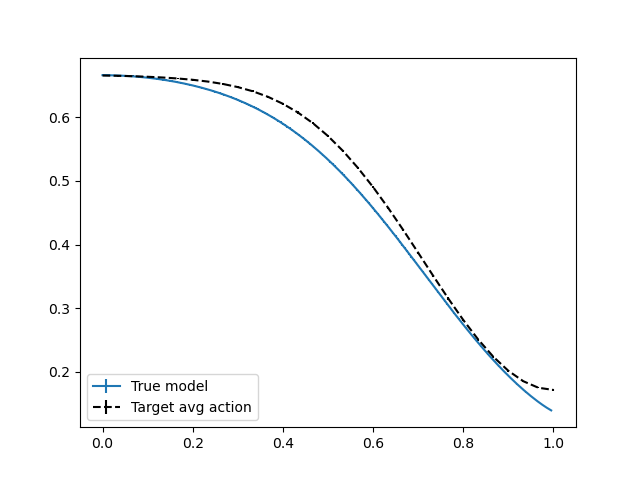

In [106]:
def run_true_model():
    batch_size = 1024
    fig, ax = plt.subplots(1,1)
    # results from actual interpolant
    ts = np.linspace(0.0, 1.0, num=31, endpoint=True)
    ens_s = eval_traj(ens1, ts, batch_size)
    print(f'{ens_s.shape=}')
    est_ens_s = al.bootstrap(ens_s, Nboot=100, f=al.rmean)
    print(f'{est_ens_s[0].shape=}')
    # results from true model
    model = TrueModel(ens1[0])
    n_step = 200
    run_eval(model, ens1, n_step, batch_size, ax, rf'True model')
    al.add_errorbar(est_ens_s, ax=ax, xs=ts, color='k', linestyle='--', label='Target avg action')
    ax.legend(loc='lower left')
    plt.show()
run_true_model()

# Regression

In [93]:
def test_true_model_loss():
    batch_size = 1024
    v = batch_size
    for di in ens1.shape[2:-1]:
        v *= di
    ts = torch.rand(batch_size)
    x0 = generate_unif(Nc, size=v).reshape((2,-1)+ens1.shape[2:]).transpose(0,1)
    x1 = ens1[np.random.randint(len(ens1), size=batch_size)]
    model = TrueModel(ens1[0])
    xt = interp(x0, x1, ts)
    bt = model(xt, ts)
    dtIt = dinterp_dt(x0, x1, ts)
    loss = (
        0.5*torch.sum(bt**2)
        - torch.sum(dtIt * bt)
        + 0.5*torch.sum(dtIt**2)
    )
    loss = loss / batch_size
    np_loss = grab(loss)
    print(f'{np_loss=}')
    assert np.allclose(np_loss, 0.0)
    print('[PASSED test_true_model_loss]')
test_true_model_loss()

np_loss=array(0.)
[PASSED test_true_model_loss]


In [94]:
def train_step(model, opt, sched, ts, x0, x1):
    """                                                                                                                   
    Given a batch of configs `(x0,x1)` and interpolant times `ts`,                                                             
    evaluate training loss and apply backprop.                                                                            
    """
    opt.zero_grad()
    batch_size = ts.shape[0]
    xt = interp(x0, x1, ts)
    bt = model(xt, ts)
    dtIt = dinterp_dt(x0, x1, ts)
    loss = (
        0.5*torch.sum(bt**2)
        - torch.sum(dtIt * bt)
        + 0.5*torch.sum(dtIt**2)
    )
    loss = loss / batch_size
    np_loss = grab(loss)
    loss.backward()
    grad_clip = float('inf')
    g = grab(torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip))
    opt.step()
    sched.step(loss)
    return dict(g=g, loss=np_loss)

In [95]:
def run_train_epoch(model, opt, sched, ens1, n_iter):
    n_cfg = len(ens1)
    batch_size = 16
    hist = dict()
    Nc = ens1.shape[-1]
    v = batch_size
    for di in ens1.shape[2:-1]:
        v *= di
    latt_shape = ens1.shape[2:-1]
    for i in tqdm.tqdm(range(n_iter), leave=False):
        ts = torch.rand(batch_size)
        x0 = generate_unif(Nc, size=v).reshape((2,-1)+ens1.shape[2:]).transpose(0,1)
        x1 = ens1[np.random.randint(len(ens1), size=batch_size)]
        res = train_step(model, opt, sched, ts, x0, x1)
        for k in res:
            if k not in hist:
                hist[k] = []
            hist[k].append(res[k])
    for k in hist:
        hist[k] = np.array(hist[k])
    return hist

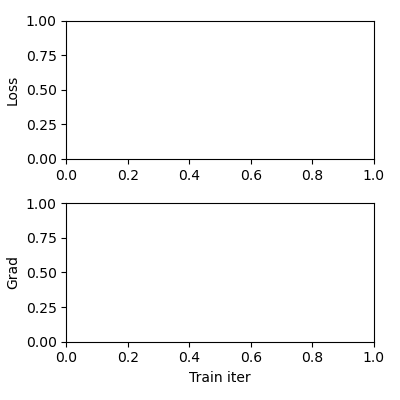

In [108]:
fig, axes = plt.subplots(2,1, figsize=(4,4))
axes[0].axhline(0.0, color='k', linewidth=0.5)
axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Grad')
axes[1].set_xlabel('Train iter')
fig.set_tight_layout(True)
plt.show()

In [111]:
def run_normal_training(fig, axes, *, res=None):
    n_epoch = 1000
    n_batch = 100
    model = VelocityField(Nc, latt_shape)
    if res is None:
        res = {}
    all_hist = dict()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=300)
    res['all_hist'] = all_hist
    res['model'] = model
    res['opt'] = opt
    line_loss, line_grad = None, None
    for i in tqdm.tqdm(range(n_epoch)):
        hist = run_train_epoch(model, opt, sched, ens1, n_batch)
        lr = opt.param_groups[0]["lr"]
        print(f'LR={lr}')
        if lr < 1e-6:
            break
        for k in hist:
            if k not in all_hist:
                all_hist[k] = []
            all_hist[k] = np.concatenate([all_hist[k], hist[k]])
        # update plots
        if line_loss is not None:
            line_loss.set_xdata(np.arange(len(all_hist['loss'])))
            line_loss.set_ydata(all_hist['loss'])
            line_grad.set_xdata(np.arange(len(all_hist['g'])))
            line_grad.set_ydata(all_hist['g'])
        else:
            line_loss, = axes[0].plot(all_hist['loss'])
            line_grad, = axes[1].plot(all_hist['g'])
        for ax in axes:
            ax.relim()
            ax.autoscale_view()
        fig.canvas.draw()
    return dict(model=model, opt=opt, all_hist=all_hist)
res = {}
run_normal_training(fig, axes, res=res)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.0005


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.0005


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.0005


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.00025


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.00025


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.00025


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.000125


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.000125


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.000125


  0%|          | 0/100 [00:00<?, ?it/s]

LR=6.25e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=6.25e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=6.25e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=3.125e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=3.125e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=3.125e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=1.5625e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=1.5625e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=1.5625e-05


  0%|          | 0/100 [00:00<?, ?it/s]

LR=7.8125e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=7.8125e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=7.8125e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=3.90625e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=3.90625e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=3.90625e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=1.953125e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=1.953125e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=1.953125e-06


  0%|          | 0/100 [00:00<?, ?it/s]

LR=9.765625e-07


{'model': VelocityField(
   (net): Sequential(
     (0): Conv2d(10, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
     (1): SiLU()
     (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
     (3): SiLU()
     (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
     (5): SiLU()
     (6): Conv2d(256, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
   )
 ),
 'opt': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 9.765625e-07
     maximize: False
     weight_decay: 0
 ),
 'all_hist': {'g': array([ 5.69917246, 10.46253969,  7.78395623, ...,  7.74956499,
          6.43588773,  8.46024238]),
  'loss': array([78.1529791 , 79.02941666, 79.03958766, ..., 77.48665287,
         77.65054838, 80.71374693])}}

  0%|          | 0/200 [00:00<?, ?it/s]

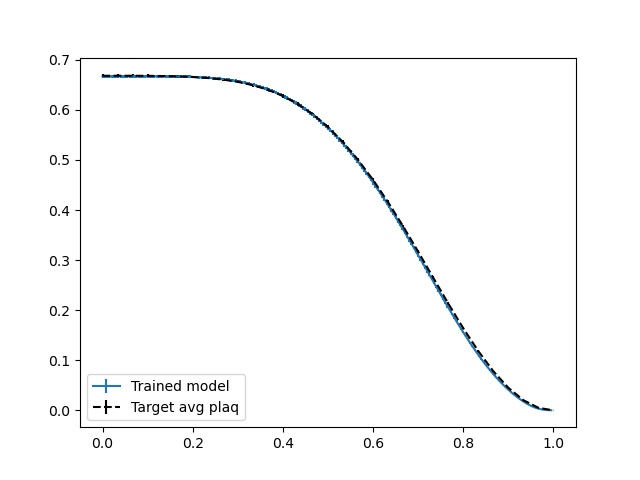

In [104]:
def run_ode_trained_model(model):
    batch_size = 256
    fig, ax = plt.subplots(1,1)
    # results from actual interpolant
    ts = np.linspace(0.0, 1.0, num=31, endpoint=True)
    ens_s = eval_traj(ens1, ts, batch_size)
    est_ens_s = al.bootstrap(ens_s, Nboot=100, f=al.rmean)
    n_step = 200
    # results from trained model
    with torch.no_grad():
        model.clamp = True
        run_eval(model, ens1, n_step, batch_size, ax, rf'Trained model')
        model.clamp = False
    # results from true model
    # model = TrueModel(ens1[0])
    # run_eval(model, ens1, n_step, batch_size, ax, rf'True model')
    al.add_errorbar(est_ens_s, ax=ax, xs=ts, color='k', linestyle='--', label='Target avg plaq')
    ax.legend(loc='lower left')
    plt.show()
run_ode_trained_model(res['model'])